# **Loan Default Prediction**



Auteurs: **SAWADOGO Issa**  
         **KPOGNON Koffi**  
         **FOMBA Abdou**  

## 1. **Introduction**

Le **défaut de paiement** est un état d'incapacité financière où une entité ne respecte pas ses obligations contractuelles envers ses créanciers **(Altman, 1968)**.  
Les déterminents du défaut de paiement sont multiples selon les recherches:   
1. Les **caractéristiques démographiques** (âge, éducation) et les **antécédents de crédits** sont déterminants **(Altman, 1968)**.  
2. L’impact des **chocs de liquidité et de l’instabilité professionnelle****(Alvarez et al., 2021)**.  
3. Le rôle crucial de **l'endettement et des garanties** **(Djankov et al., 2008)**.    
4. La supériorité prédictive des **données de transactions bancaires** **(Berg et al., 2022)**.
5. Récemment, **Chen et al. (2023)** exploitent l'intelligence artificielle pour identifier de nouveaux facteurs prédictifs à partir de données massives, confirmant la complexité multifactorielle du risque.  

L'objectif de notre étude vise à prédire le risque de défaut de paiement à l'aide de plusieurs facteurs explicatifs et en usant des modèles connus dans la littérature et à l'aide récentes techniques du machine learning comme présentés dans le tableau ci dessous. Les données proviennent de **Kaggle** mais la source primaire est de **LendingClub**.

| Modèle                     | Performance | Interprétabilité | Robustesse | Complexité | Cas d'Usage Recommandé                                  |
|----------------------------|:-----------:|:----------------:|:----------:|:----------:|---------------------------------------------------------|
| **Régression Logistique**  |     ▲▲△     |       ★★★        |    ★★★     |     △△△    | Base de référence, exigence réglementaire forte         |
| **Arbres de Décision**     |     ▲△△     |       ★★★        |    ▲△△     |     ▲△△    | Prototypage, règles métier simples                      |
| **Random Forest**          |     ▲▲▲     |       ▲▲△        |    ★★★     |     ▲▲△    | Benchmark solide, équilibre performance/interprétation  |
| **XGBoost/LightGBM**/**CatBoost**       |     ★★★     |       ▲▲△        |    ▲▲▲     |     ▲▲▲    | **Meilleure performance pure**   |
| **Réseaux de Neurones**    |     ★★★     |        △△△       |    ▲▲△     |     ★★★    | Très grands volumes de données (big data)               |
| **Stacking Ensemble**      |     ★★★     |        △△△       |    ▲▲▲     |     ★★★    | Projets avancés où chaque gain de performance compte    |

**Légende** :<br>
★★★ Excellent | ▲▲▲ Très Bon | ▲▲△ Bon | ▲△△ Moyen | △△△ Faible

## 2. **Chargement de la base de données et installation de librairies**

In [ ]:
!pip install -q gdown
!pip install catboost

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import keras
from keras.layers import Dense


file_id = "1t7fCjZneSb8yAEiJ3O8OnHgD2MupxVK9"
url = f"https://drive.google.com/uc?id={file_id}"
filename = "Loan_default.csv"
gdown.download(url, filename, quiet=False)


df = pd.read_csv(filename)
df.head()

Downloading...
From: https://drive.google.com/uc?id=1t7fCjZneSb8yAEiJ3O8OnHgD2MupxVK9
To: /content/Loan_default.csv
100%|██████████| 24.8M/24.8M [00:00<00:00, 88.1MB/s]


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


## 3. **Exploration de la base de données et détection d'anomalies**

#### 3.1. Vérification des données manquantes, données dupliquées de la base et de la typologie des variables

In [ ]:
df.isna().sum()

,0
LoanID,0
Age,0
Income,0
LoanAmount,0
CreditScore,0
MonthsEmployed,0
NumCreditLines,0
InterestRate,0
LoanTerm,0
DTIRatio,0


*La base de données ne comporte pas de données manquantes*

In [ ]:
nombre_de_doublons = df.duplicated().sum()

print(f"Nombre de lignes en double dans le DataFrame : {nombre_de_doublons}")

Nombre de lignes en double dans le DataFrame : 0


*La base ne comporte pas de doublons*.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [ ]:
df.shape

(255347, 18)

*La base initiale est comporte 18 colonnes et 255347 observations*

#### 3.2. Définition exacte des variables

| Variable | Définition | Valeurs non-nulles | Type de données |
| :--- | :--- | :--- | :--- |
| **LoanID** | Identifiant unique du prêt | 255347 | `object` (chaîne de caractères) |
| **Age** | Âge du demandeur | 255347 | `int64` (entier) |
| **Income** | Revenu annuel du demandeur | 255347 | `int64` (entier) |
| **LoanAmount** | Montant du prêt demandé | 255347 | `int64` (entier) |
| **CreditScore** | Cote de crédit du demandeur | 255347 | `int64` (entier) |
| **MonthsEmployed** | Nombre de mois d'emploi du demandeur | 255347 | `int64` (entier) |
| **NumCreditLines** | Nombre de lignes de crédit ouvertes | 255347 | `int64` (entier) |
| **InterestRate** | Taux d'intérêt du prêt | 255347 | `float64` (décimal) |
| **LoanTerm** | Durée du prêt en mois | 255347 | `int64` (entier) |
| **DTIRatio** | Ratio dette sur revenu | 255347 | `float64` (décimal) |
| **Education** | Niveau d'éducation du demandeur | 255347 | `object` (chaîne de caractères) |
| **EmploymentType** | Type d'emploi du demandeur | 255347 | `object` (chaîne de caractères) |
| **MaritalStatus** | État civil du demandeur | 255347 | `object` (chaîne de caractères) |
| **HasMortgage** | Indicateur de l'existence d'un prêt hypothécaire | 255347 | `object` (chaîne de caractères) |
| **HasDependents** | Indicateur de l'existence de personnes à charge | 255347 | `object` (chaîne de caractères) |
| **LoanPurpose** | Raison de la demande de prêt | 255347 | `object` (chaîne de caractères) |
| **HasCoSigner** | Indicateur de l'existence d'un cosignataire | 255347 | `object` (chaîne de caractères) |
| **Default** | Variable cible : 1 si défaut de paiement, 0 sinon | 255347 | `int64` (entier) |

### 3.3. Analyse graphique des données

/tmp/ipython-input-2605156197.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_counts.index, y=default_counts.values, palette='viridis')


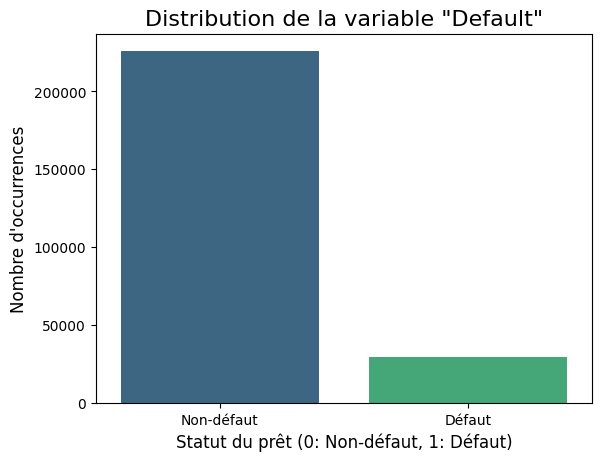

In [ ]:
# Graphique parplot du défaut de paiement

default_counts = df['Default'].value_counts()

sns.barplot(x=default_counts.index, y=default_counts.values, palette='viridis')

plt.title('Distribution de la variable "Default"', fontsize=16)
plt.xlabel('Statut du prêt (0: Non-défaut, 1: Défaut)', fontsize=12)
plt.ylabel('Nombre d\'occurrences', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-défaut', 'Défaut'])

plt.show()

*On a un dataset déséquilibré(le non défaut a plus de modalités par rapport au défaut de paiement), qui permet de tirer des informations sur la suite de l'analyse.*  
*Premièrement, cela nous donne une bonne information sur les bonnes métriques qui seront utilisées dans la suite de l'analyse, à savoir la précision et le recall mais moins l'accuracy.*  
*Deuxiemement, lors de la définition du modèle de machine learning, on va pénaliser le modèle plus durement lorsqu'il prédit un non défaut de paiement alors qu'il y avait un défaut de paiement.*

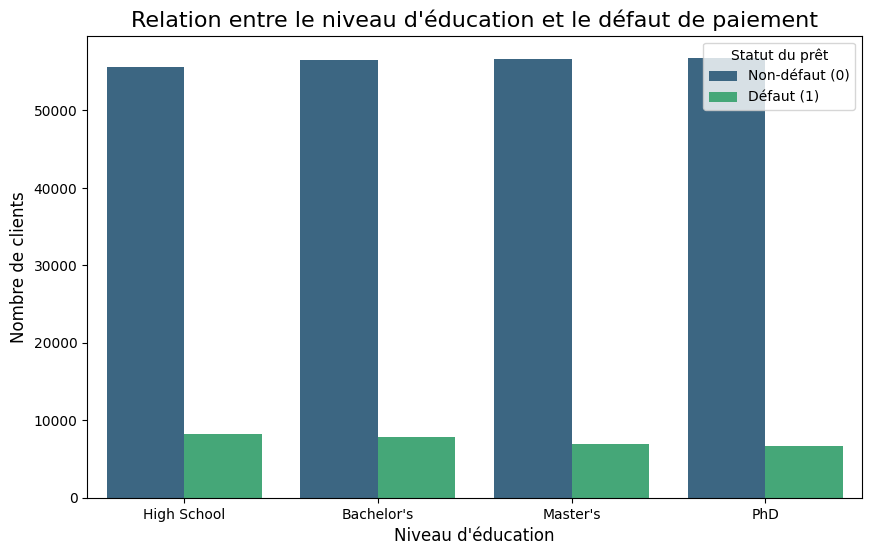

In [ ]:
# Graphique de la relation entre niveau d'éducation et défaut de paiement

education_order = ["High School", "Bachelor's", "Master's", "PhD"]

plt.figure(figsize=(10, 6))
sns.countplot(x='Education', hue='Default', data=df, order=education_order, palette='viridis')

plt.title('Relation entre le niveau d\'éducation et le défaut de paiement', fontsize=16)
plt.xlabel('Niveau d\'éducation', fontsize=12)
plt.ylabel('Nombre de clients', fontsize=12)

plt.legend(title='Statut du prêt', labels=['Non-défaut (0)', 'Défaut (1)'])

plt.show()

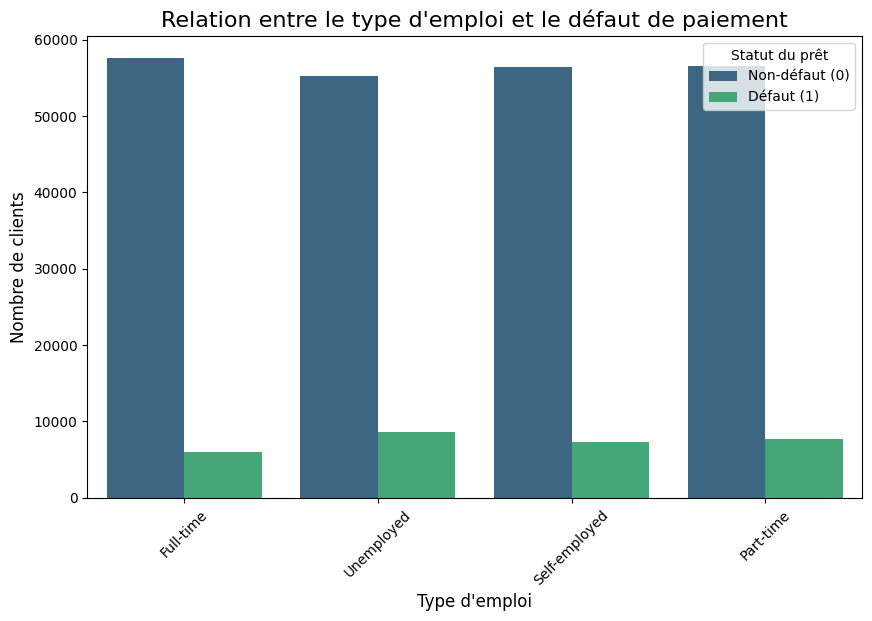

In [ ]:
# Graphique de la relation entre Type d'emploi et défaut de paiement

plt.figure(figsize=(10, 6))
sns.countplot(x='EmploymentType', hue='Default', data=df, palette='viridis')

plt.title('Relation entre le type d\'emploi et le défaut de paiement', fontsize=16)
plt.xlabel('Type d\'emploi', fontsize=12)
plt.ylabel('Nombre de clients', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Statut du prêt', labels=['Non-défaut (0)', 'Défaut (1)'])

plt.show()

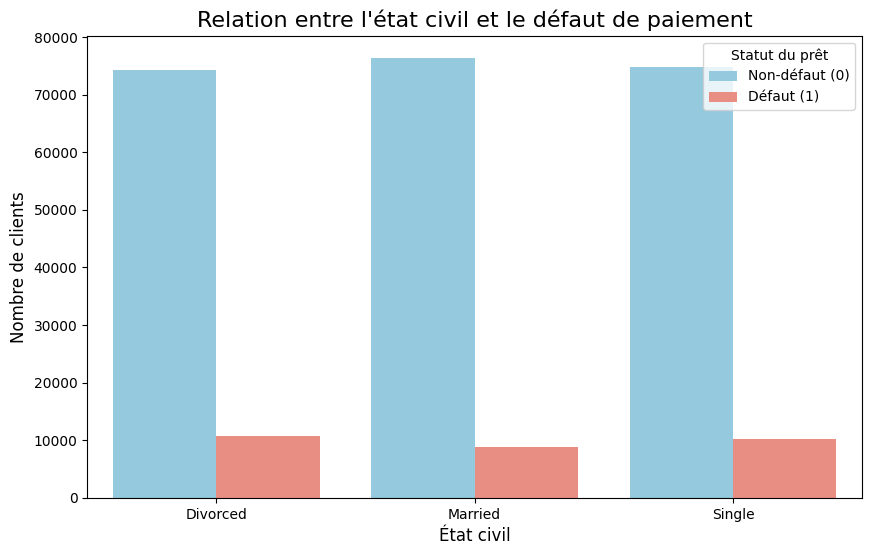

In [ ]:
# Graphique de la relation de l'état civil et le défaut de paiement

palette = {0: 'skyblue', 1: 'salmon'}

plt.figure(figsize=(10, 6))
sns.countplot(x='MaritalStatus', hue='Default', data=df, palette=palette)


plt.title('Relation entre l\'état civil et le défaut de paiement', fontsize=16)
plt.xlabel('État civil', fontsize=12)
plt.ylabel('Nombre de clients', fontsize=12)

plt.legend(title='Statut du prêt', labels=['Non-défaut (0)', 'Défaut (1)'])

plt.show()

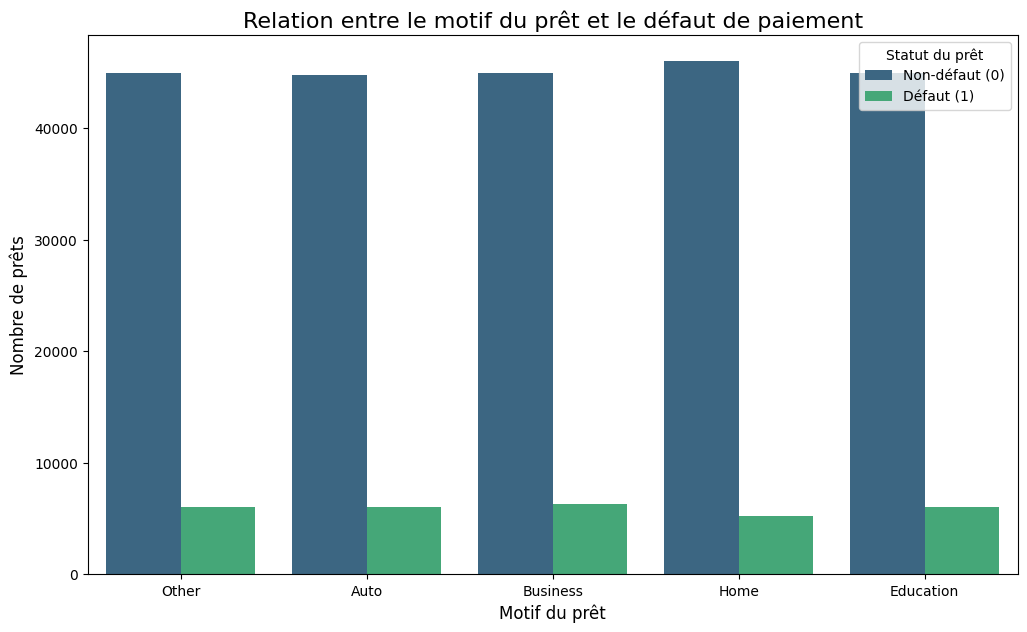

In [ ]:
# Graphique de la Relation entre le motif du prêt et le défaut de paiement

plt.figure(figsize=(12, 7))
sns.countplot(x='LoanPurpose', hue='Default', data=df, palette='viridis')


plt.title('Relation entre le motif du prêt et le défaut de paiement', fontsize=16)
plt.xlabel('Motif du prêt', fontsize=12)
plt.ylabel('Nombre de prêts', fontsize=12)

plt.legend(title='Statut du prêt', labels=['Non-défaut (0)', 'Défaut (1)'])

plt.show()

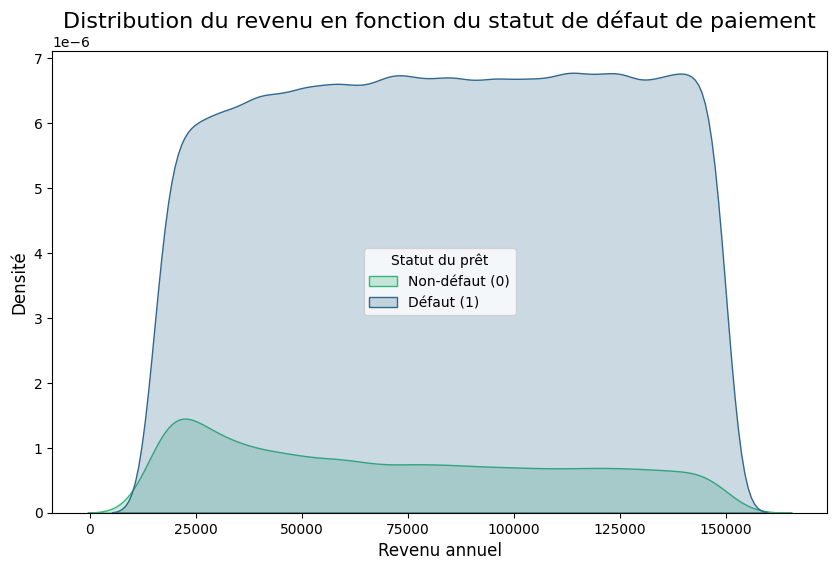

In [ ]:
# Graphique de Distribution du revenu en fonction du statut de défaut de paiement
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Income', hue='Default', fill=True, palette='viridis')

plt.title('Distribution du revenu en fonction du statut de défaut de paiement', fontsize=16)
plt.xlabel('Revenu annuel', fontsize=12)
plt.ylabel('Densité', fontsize=12)

plt.legend(title='Statut du prêt', labels=['Non-défaut (0)', 'Défaut (1)'])

plt.show()

/tmp/ipython-input-3269551126.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Default', y='LoanAmount', data=df, palette='muted')


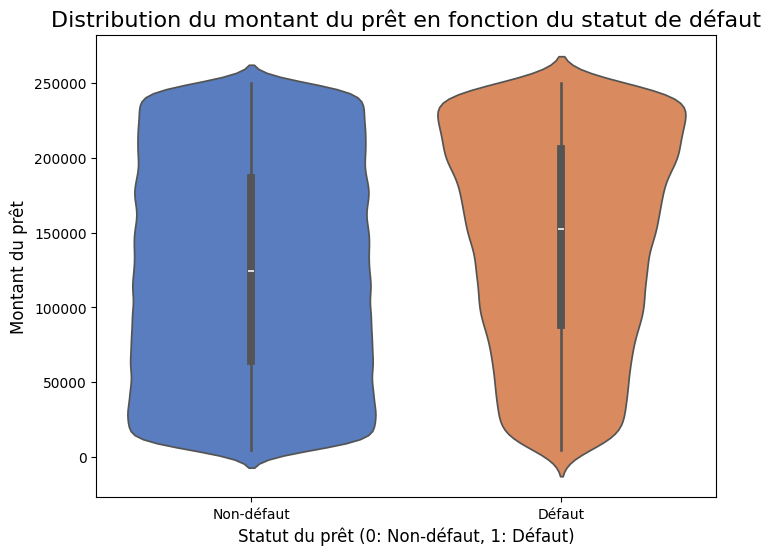

In [ ]:
# Diagramme en violon pour comparer la distribution de LoanAmount par statut de défaut
plt.figure(figsize=(8, 6))
sns.violinplot(x='Default', y='LoanAmount', data=df, palette='muted')

plt.title('Distribution du montant du prêt en fonction du statut de défaut', fontsize=16)
plt.xlabel('Statut du prêt (0: Non-défaut, 1: Défaut)', fontsize=12)
plt.ylabel('Montant du prêt', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-défaut', 'Défaut'])

plt.show()

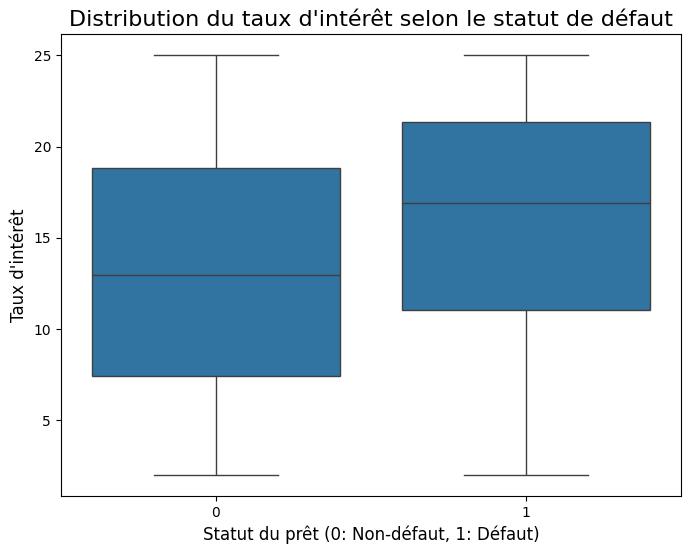

In [ ]:
# Diagramme en boîte
plt.figure(figsize=(8, 6))
sns.boxplot(x='Default', y='InterestRate', data=df)

plt.title('Distribution du taux d\'intérêt selon le statut de défaut', fontsize=16)
plt.xlabel('Statut du prêt (0: Non-défaut, 1: Défaut)', fontsize=12)
plt.ylabel('Taux d\'intérêt', fontsize=12)

plt.show()

## 4. Transformation des variables de type object en  numériques et nettoyage de la base

In [ ]:
# Transformation de la variable Education

education_counts = df['Education'].value_counts()

print(education_counts)

Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64


In [ ]:
  education_mapping = {
    "High School": 0,
    "Bachelor's": 1,
    "Master's": 2,
    "PhD": 3
}

df['Education_encoded'] = df['Education'].map(education_mapping)

In [ ]:
# Vérification des modalités des colonnes EmploymentType, MaritalStatus, HasMortgage, HasDependents, LoanPurpose, HasCoSigner

In [ ]:
      # Modalités de EmploymentType
employment_counts = df['EmploymentType'].value_counts()

print(employment_counts)

EmploymentType
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: count, dtype: int64


In [ ]:
      # Modalités de MaritalStatus
MaritalStatus_counts = df['MaritalStatus'].value_counts()

print(MaritalStatus_counts)

MaritalStatus
Married     85302
Divorced    85033
Single      85012
Name: count, dtype: int64


In [ ]:
      # Modalités de HasMortgage
HasMortgage_counts = df['HasMortgage'].value_counts()

print(HasMortgage_counts)

HasMortgage
Yes    127677
No     127670
Name: count, dtype: int64


In [ ]:
      # Modalités de HasDependents
HasDependents_counts = df['HasDependents'].value_counts()

print(HasDependents_counts)

HasDependents
Yes    127742
No     127605
Name: count, dtype: int64


In [ ]:
       # Modalités de LoanPurpose
LoanPurpose_counts = df['LoanPurpose'].value_counts()

print(LoanPurpose_counts)

LoanPurpose
Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: count, dtype: int64


In [ ]:
       # Modalités de HasCoSigner
HasCoSigner_counts = df['HasCoSigner'].value_counts()

print(HasCoSigner_counts)

HasCoSigner
Yes    127701
No     127646
Name: count, dtype: int64


In [ ]:
# Transformation des colonnes (EmploymentType, MaritalStatus, HasMortgage, HasDependents, LoanPurpose, HasCoSigner) en numérique

categorical_cols = ['EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

dummies = pd.get_dummies(df[categorical_cols])

dummies = dummies.astype(int)

df = df.drop(columns=categorical_cols)

df_final = pd.concat([df, dummies], axis=1)

print("DataFrame avec dummies ajoutées et converties en entiers :")
df_final.head()

DataFrame avec dummies ajoutées et converties en entiers :


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,1,0,1,0,0,0,0,1,0,1
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,0,1,0,0,0,0,0,1,0,1
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,1,0,1,1,0,0,0,0,1,0
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,0,1,0,0,1,0,0,0,1,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,0,0,1,1,0,0,0,0,1,0


In [ ]:
#Suppression des colonnes non numériques inutiles restantes
df_final = df_final.drop(['LoanID','Education'], axis=1)

In [ ]:
df_final.shape

(255347, 29)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           255347 non-null  int64  
 1   Income                        255347 non-null  int64  
 2   LoanAmount                    255347 non-null  int64  
 3   CreditScore                   255347 non-null  int64  
 4   MonthsEmployed                255347 non-null  int64  
 5   NumCreditLines                255347 non-null  int64  
 6   InterestRate                  255347 non-null  float64
 7   LoanTerm                      255347 non-null  int64  
 8   DTIRatio                      255347 non-null  float64
 9   Default                       255347 non-null  int64  
 10  Education_encoded             255347 non-null  int64  
 11  EmploymentType_Full-time      255347 non-null  int64  
 12  EmploymentType_Part-time      255347 non-nul

## 5. Modèles d'analyse du risque de défaut

### 5.1. Regression Logistique avec une regularisation L1 et choix des variables les plus importantes

/tmp/ipython-input-1987246517.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients_importants.values, y=coefficients_importants.index, palette='viridis')


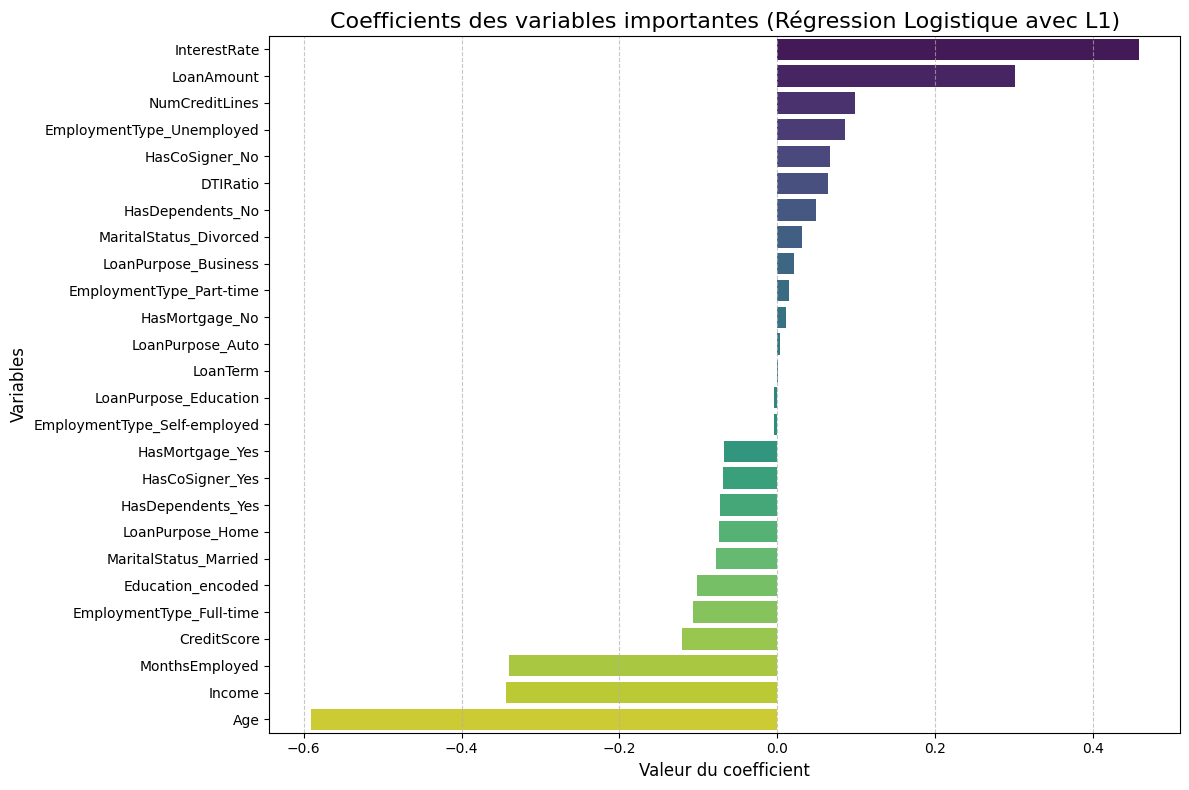

In [ ]:
# Séparation des variables explicatives (X) et la variable cible (y)
X = df_final.drop('Default', axis=1)
y = df_final['Default']

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Régression logistique avec pénalité L1
log_reg_l1 = LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=42)
log_reg_l1.fit(X_scaled, y)

# Trie des coefficients
coefficients = pd.Series(log_reg_l1.coef_[0], index=X.columns)
coefficients_importants = coefficients[coefficients != 0].sort_values(ascending=False)

# Graphique à barres des coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x=coefficients_importants.values, y=coefficients_importants.index, palette='viridis')
plt.title('Coefficients des variables importantes (Régression Logistique avec L1)', fontsize=16)
plt.xlabel('Valeur du coefficient', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


*À la lecture de ce graphe, il ressort que les trois premiéres variables les importantes qui influencent négativement le risque de défaut sont les variables Age, Income,MonthsEmployed tandis que les trois premiéres variables qui influencent positivement le risque de défaut sont les variables InterestRate, LoanAmount et NumCreditLines*

In [ ]:
# Sélectionn des variables les importantes

coefficients = pd.Series(log_reg_l1.coef_[0], index=X.columns)

variables_importantes = coefficients[coefficients != 0].index.tolist()

print("Variables sélectionnées par la régression logistique avec pénalité L1 :")
print(variables_importantes)
# DataFrame des variables les plus importantes
X_log_reg_l1 = X[variables_importantes]

Variables sélectionnées par la régression logistique avec pénalité L1 :
['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education_encoded', 'EmploymentType_Full-time', 'EmploymentType_Part-time', 'EmploymentType_Self-employed', 'EmploymentType_Unemployed', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'HasMortgage_No', 'HasMortgage_Yes', 'HasDependents_No', 'HasDependents_Yes', 'LoanPurpose_Auto', 'LoanPurpose_Business', 'LoanPurpose_Education', 'LoanPurpose_Home', 'HasCoSigner_No', 'HasCoSigner_Yes']


### 5.2. Séparation des données en données d'entrainement et de validation, Normalisation des données, Calcul des poids des classes

In [ ]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_log_reg_l1, y, test_size=0.2, random_state=42
)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
np.sum(y_train)/len(y_train)

np.float64(0.1162783867004117)

In [ ]:
np.sum(y_test)/len(y_test)

np.float64(0.1155277070687292)

*Il n'y a pas un écart entre le pourcentage de cas de défaut de paiement dans le jeu de données d'entrainement et de validation. Les deux données suivent presque la même distribution.*

In [ ]:
# Calcul des poids pour la pondération
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

weight_for_0 = 1/(n_neg)
weight_for_1 = 1/(n_pos)

(weight_for_0, weight_for_1)

(np.float64(5.5394296603221735e-06), np.float64(4.2099945270071146e-05))

### 5.3. Modèle de régression logistique avec les variables les plus importantes

In [ ]:
# Modèle de régression logistique
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

# Prédictions sur le jeu de test
y_pred_log = log_reg_model.predict(X_test_scaled)
y_pred_proba_log = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# Évaluation des performances du modèle
print("--- Évaluation du modèle de régression logistique ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_log):.4f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred_log))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_log))

# Visualisation des 3 premières lignes de prédictions
print("\nPrédictions sur le jeu de test :")
print(y_pred_log[:3])

--- Évaluation du modèle de régression logistique ---
Accuracy: 0.8859
ROC AUC: 0.7525

Matrice de confusion:
[[45048   122]
 [ 5706   194]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.61      0.03      0.06      5900

    accuracy                           0.89     51070
   macro avg       0.75      0.52      0.50     51070
weighted avg       0.86      0.89      0.84     51070


Prédictions sur le jeu de test :
[0 0 0]


### 5.4. Modèle d'Arbre de décision

In [ ]:
# modèle d'arbre de décision

dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Performance du modèle
print("--- Évaluation du Modèle d'Arbre de Décision ---")
print(f"Précision (Accuracy) : {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_dt))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_dt))

# 3 premières lignes de prédictions
print("\nPrédictions sur le jeu de test :")
print(y_pred_dt[:3])

--- Évaluation du Modèle d'Arbre de Décision ---
Précision (Accuracy) : 0.8854
ROC AUC: 0.7155

Matrice de confusion :
[[45082    88]
 [ 5763   137]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.61      0.02      0.04      5900

    accuracy                           0.89     51070
   macro avg       0.75      0.51      0.49     51070
weighted avg       0.85      0.89      0.84     51070


Prédictions sur le jeu de test :
[0 0 0]


### 5.5. Modèle de random forest

In [ ]:
# random_state: pour la reproductibilité
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

#  les performances du modèle
print("--- Évaluation du Modèle de Forêt Aléatoire ---")
print(f"Précision (Accuracy) : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_rf))

# Les 3 premières lignes de prédictions
print("\nPrédictions sur le jeu de test :")
print(y_pred_rf[:3])

--- Évaluation du Modèle de Forêt Aléatoire ---
Précision (Accuracy) : 0.8869
ROC AUC: 0.7313

Matrice de confusion :
[[45062   108]
 [ 5667   233]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.68      0.04      0.07      5900

    accuracy                           0.89     51070
   macro avg       0.79      0.52      0.51     51070
weighted avg       0.86      0.89      0.84     51070


Prédictions sur le jeu de test :
[0 0 0]


### 5.6. Modèle XGBoost

In [ ]:

# Modèle XGBoost
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    early_stopping_rounds=10,
    random_state=42
)


xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Prédiction et évaluation
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("--- Évaluation du Modèle XGBoost ---")
print(f"Précision (Accuracy) : {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_xgb))

# les 3 premières lignes de prédictions
print("\nPrédictions sur le jeu de test :")
print(y_pred_xgb[:3])

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:31:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


--- Évaluation du Modèle XGBoost ---
Précision (Accuracy) : 0.8876
ROC AUC : 0.7565

Matrice de confusion :
[[44930   240]
 [ 5501   399]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45170
           1       0.62      0.07      0.12      5900

    accuracy                           0.89     51070
   macro avg       0.76      0.53      0.53     51070
weighted avg       0.86      0.89      0.85     51070


Prédictions sur le jeu de test :
[0 0 0]


### 5.7. Modèle LGBM

In [ ]:
# modèle LightGBM

lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42
)

lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Prédiction et évaluation
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

print("--- Évaluation du Modèle LightGBM ---")
print(f"Précision (Accuracy) : {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_lgbm))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 23753, number of negative: 180524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116278 -> initscore=-2.028155
[LightGBM] [Info] Start training from score -2.028155
--- Évaluation du Modèle LightGBM ---
Précision (Accuracy) : 0.8871
ROC AUC : 0.7453

Matrice de confusion :
[[44800   370]
 [ 5398   502]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45170
           1       0.58      0.09      0.15      5900

    accuracy                           0.89     51070
   macro avg       0.73      0.54      0.54     51070

### 5.8.  Modèle CatBoost

In [ ]:
# Modèle CatBoost
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    random_seed=42,
    #class_weights=[1, len(y_train[y_train==0]) / len(y_train[y_train==1])],
    verbose=0
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)

# Prédictions
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
y_pred_cat = (y_pred_proba_cat > 0.5).astype(int)



# Évaluation du modèle CatBoost
print("--- Évaluation du Modèle CatBoost ---")
print(f"Précision (Accuracy) : {accuracy_score(y_test, y_pred_cat):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_pred_proba_cat):.4f}")
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_cat))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_cat))

# Les 3 premières lignes de prédictions
print("\nPrédictions sur le jeu de test :")
print(y_pred_cat[:3])

--- Évaluation du Modèle CatBoost ---
Précision (Accuracy) : 0.8881
ROC AUC : 0.7603

Matrice de confusion :
[[44953   217]
 [ 5500   400]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.65      0.07      0.12      5900

    accuracy                           0.89     51070
   macro avg       0.77      0.53      0.53     51070
weighted avg       0.86      0.89      0.85     51070


Prédictions sur le jeu de test :
[0 0 0]


### 5.9. Réseaux de neurones

In [ ]:
# modèle réseaux de neurones
model_rn = keras.Sequential([
    keras.Input(shape=X_train.shape[1:]),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid")
])

model_rn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,753 (542.00 KB)

 Trainable params: 138,753 (542.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Métriques et compilation du modèle
metrics = [
  keras.metrics.AUC(name='ROC AUC'),
  keras.metrics.BinaryAccuracy(name="accuracy"),
  keras.metrics.Precision(name="precision"),
  keras.metrics.Recall(name="recall"),

]

model_rn.compile(
  optimizer=keras.optimizers.Adam(),
  loss="binary_crossentropy",
  metrics=metrics
)


In [ ]:
# Entrainement du modèle et résultats
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model_rn.fit(
  X_train_scaled,
  y_train,
  batch_size=2500,
  epochs=10,
  verbose=2,
  validation_data=(X_test_scaled, y_test)
  #class_weight=class_weight
)

Epoch 1/10
82/82 - 9s - 108ms/step - ROC AUC: 0.6985 - accuracy: 0.8828 - loss: 0.3361 - precision: 0.1265 - recall: 0.0013 - val_ROC AUC: 0.7489 - val_accuracy: 0.8846 - val_loss: 0.3149 - val_precision: 0.7368 - val_recall: 0.0024
Epoch 2/10
82/82 - 11s - 128ms/step - ROC AUC: 0.7427 - accuracy: 0.8849 - loss: 0.3183 - precision: 0.5879 - recall: 0.0341 - val_ROC AUC: 0.7516 - val_accuracy: 0.8866 - val_loss: 0.3129 - val_precision: 0.6412 - val_recall: 0.0427
Epoch 3/10
82/82 - 5s - 62ms/step - ROC AUC: 0.7482 - accuracy: 0.8852 - loss: 0.3159 - precision: 0.5770 - recall: 0.0484 - val_ROC AUC: 0.7547 - val_accuracy: 0.8874 - val_loss: 0.3114 - val_precision: 0.6349 - val_recall: 0.0586
Epoch 4/10
82/82 - 6s - 78ms/step - ROC AUC: 0.7512 - accuracy: 0.8856 - loss: 0.3145 - precision: 0.5838 - recall: 0.0576 - val_ROC AUC: 0.7551 - val_accuracy: 0.8874 - val_loss: 0.3114 - val_precision: 0.6208 - val_recall: 0.0658
Epoch 5/10
82/82 - 9s - 106ms/step - ROC AUC: 0.7538 - accuracy: 0.88

In [ ]:
history.history

{'loss': [0.30480578541755676,
  0.30336081981658936,
  0.3023799657821655,
  0.3014568090438843,
  0.3006552457809448,
  0.2994349002838135,
  0.29895463585853577,
  0.29761460423469543,
  0.29675135016441345,
  0.29497671127319336],
 'precision': [0.6054942011833191,
  0.607395350933075,
  0.6144149303436279,
  0.6236934065818787,
  0.6114419102668762,
  0.6168562769889832,
  0.6158567667007446,
  0.6229548454284668,
  0.6170264482498169,
  0.635633647441864],
 'recall': [0.09000968188047409,
  0.09405127912759781,
  0.09438807517290115,
  0.09796657413244247,
  0.0994400680065155,
  0.10045047104358673,
  0.10137666761875153,
  0.10739696025848389,
  0.10710225999355316,
  0.10663916170597076],
 'val_loss': [0.3136829137802124,
  0.3144863545894623,
  0.3139336407184601,
  0.3159017264842987,
  0.31551510095596313,
  0.3171411156654358,
  0.3169921636581421,
  0.3176703453063965,
  0.3180353343486786,
  0.3197057545185089],
 'val_precision': [0.5461121201515198,
  0.6038216352462769

##  Inférence dans le Modèle des réseaux de neurones

In [ ]:
val_pred = model_rn.predict(X_train_scaled)

6384/6384 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


In [ ]:
val_pred

array([[0.33557558],
       [0.1575917 ],
       [0.1726823 ],
       ...,
       [0.05978656],
       [0.03005154],
       [0.351904  ]], dtype=float32)

In [ ]:
val_pred[:,0]>0.5

array([False, False, False, ..., False, False, False])

In [ ]:
(val_pred[:,0]>0.5).mean()

np.float64(0.021651972566661935)

In [ ]:
#Faire des prédictions sur les données de test
y_pred_proba = model_rn.predict(X_test_scaled)
y_pred_classes = (y_pred_proba > 0.5).astype("int64")

# 2. Calculer et afficher la matrice de confusion et le F1-score
print("\n--- Métriques d'évaluation post-entraînement ---")
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_classes))
print("\nF1-score :")
print(f1_score(y_test, y_pred_classes))

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

--- Métriques d'évaluation post-entraînement ---
Matrice de confusion :
[[44778   392]
 [ 5380   520]]

F1-score :
0.15267175572519084


###Comparaison des modèles à partir de leurs métriques respectives

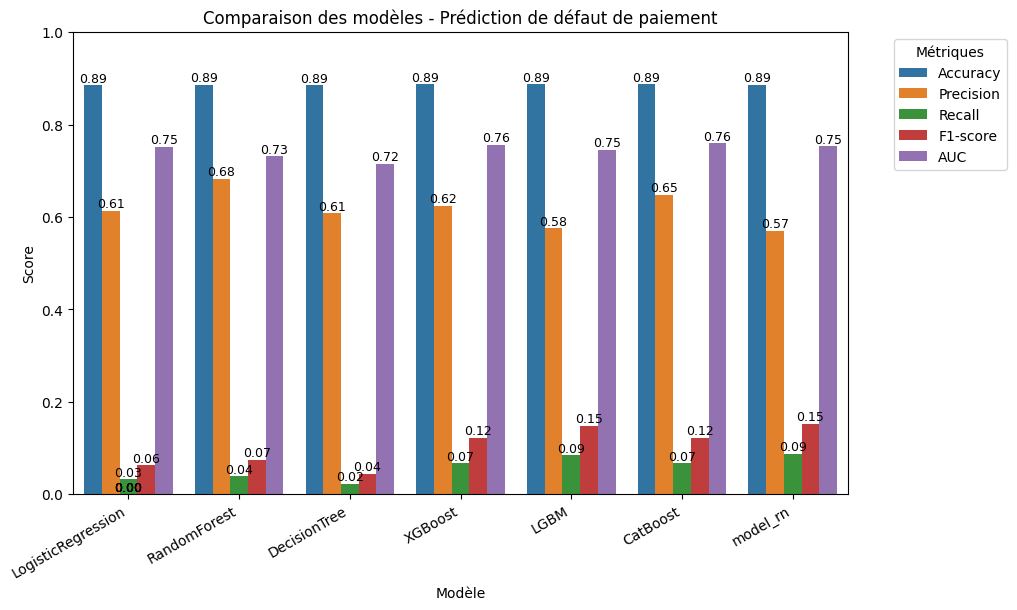

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_test
dict_preds = { "LogisticRegression": y_pred_log, "RandomForest": y_pred_rf, "DecisionTree": y_pred_dt, "XGBoost": y_pred_xgb, "LGBM":y_pred_lgbm, "CatBoost":y_pred_cat, "model_rn": y_pred_classes}
dict_probas = { "LogisticRegression": y_pred_proba_log, "RandomForest": y_pred_proba_rf, "DecisionTree": y_pred_proba_dt, "XGBoost": y_pred_proba_xgb, "LGBM":y_pred_proba_lgbm, "CatBoost":y_pred_proba_cat, "model_rn": y_pred_proba}

results = []

for model_name in dict_preds.keys():
    y_pred = dict_preds[model_name]
    y_proba = dict_probas[model_name]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
      "Modèle": model_name,
      "Accuracy": acc,
      "Precision": prec,
      "Recall": rec,
      "F1-score": f1,
      "AUC": auc
     })

# Convertir en DataFrame
df_results = pd.DataFrame(results)

# Transformation longue (pour seaborn)
df_melt = df_results.melt(id_vars="Modèle", var_name="Métrique", value_name="Score")

# Tracé
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Modèle", y="Score", hue="Métrique", data=df_melt)
plt.title("Comparaison des modèles - Prédiction de défaut de paiement")
# Rotation des labels en abscisse
plt.xticks(rotation=30, ha="right")
# Ajouter les valeurs au-dessus des barres
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, rotation=0)
plt.ylim(0, 1)
plt.legend(title="Métriques", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

###D'après le graphe, on a deux modèles concurrentiels en terme de performance: les modèles des resaux de neurones et le modèle LightGBM

Modèle LightGBM + SHAP

In [ ]:
X_test_sampled = X_test.sample(n=5000, random_state=42)

explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test_sampled)

##Conclusion

Apres avoir implémenté les différents modèles, le choix en terme de performance a porté sur les modèles de resaux de neurones et LightGBM. Mais en termes de perspectives, on pourrait faire un stacking ensemble pour avoir des métriques plus interessantes.

## Bibliographie

Alvarez, F., Argente, D., & Van Patten, D. (2021). *Are Cryptocurrencies Currencies? Manna from Heaven or Toxic Pollution?* (No. w29356). National Bureau of Economic Research.

Altman, E. I. (1968). Financial ratios, discriminant analysis and the prediction of corporate bankruptcy. *The Journal of Finance, 23*(4), 589-609.

Bazarbash, M. (2019). *FinTech in financial inclusion: Machine learning applications in assessing credit risk*. International Monetary Fund.

Becker, G. S. (1968). Crime and punishment: An economic approach. *Journal of Political Economy, 76*(2), 169-217.

Berg, T., Burg, V., Gombović, A., & Puri, M. (2020). On the rise of fintechs: Credit scoring using digital footprints. *The Review of Financial Studies, 33*(7), 2845-2897.

Chen, M. X., Wu, S., & Yang, B. (2023). How valuable is FinTech innovation? *The Review of Financial Studies, 36*(2), 633-677.

D'Acunto, F., Prabhala, N., & Rossi, A. G. (2022). The promises and pitfalls of robo-advising. *The Review of Financial Studies, 35*(7), 3178-3220.

Djankov, S., McLiesh, C., & Shleifer, A. (2007). Private credit in 129 countries. *Journal of Financial Economics, 84*(2), 299-329.
Bastani, K., Asgari, E., & Namavari, H. (2019). Wide and deep learning for peer-to-peer lending. Expert Systems with Applications, 134, 209-224.

Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.

Ke, G., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., ... & Liu, T. Y. (2017). Lightgbm: A highly efficient gradient boosting decision tree. Advances in neural information processing systems, 30.

Nieto, M. R., Fernández, A., & Figuerola, C. G. (2018). A new ensemble-based method for credit scoring. Economic Research-Ekonomska Istraživanja, 31(1), 1274-128